# Fitting the wavefront metrology data

In [1]:
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
# import pyrost as rst
from tqdm.notebook import tqdm, trange

# from multiprocessing import Pool
# from itertools import repeat
# import time

from scipy.optimize import curve_fit
from scipy.optimize import minimize

from ZernikePolynomials import RectangularPolynomials

# plt.set_cmap("RdBu")

In [54]:
def extract_rectangular_coefficients(phase, a=1/np.sqrt(2)):
    """
    Extract rectangular polynomial coefficients from a phase map.
    
    Parameters:
    -----------
    phase : numpy.ndarray
        2D phase array to decompose
    a : float
        Rectangularity parameter (default: 1/sqrt(2) for square)
    
    Returns:
    --------
    list
        List of coefficients for R1 through R15
    """
    
    # Create the polynomial object
    rect_poly = RectangularPolynomials(a=a)
    
    # Create coordinate grids
    side_x = np.linspace(-a, a, phase.shape[1])
    side_y = np.linspace(-np.sqrt(1-a**2), np.sqrt(1-a**2), phase.shape[0])
    
    X1, X2 = np.meshgrid(side_x, side_y)
    size = X1.shape
    
    # Reshape coordinates for curve_fit
    x1_1d = X1.reshape((1, np.prod(size)))
    x2_1d = X2.reshape((1, np.prod(size)))
    xdata_curve_fit = np.vstack((x1_1d, x2_1d))
    
    # Reshape phase data
    psize = phase.shape
    p_shape = phase.reshape(np.prod(psize))
    
    # Get list of function names
    function_names = rect_poly.get_function_list()
    
    coefflist_rect = []
    
    # Method 1: Using the evaluate method
    for i in range(len(function_names)):
        func_name = function_names[i]
        
        # Create a wrapper function for curve_fit
        def poly_wrapper(xdata, A):
            X1_reshaped = xdata[0].reshape(size)
            X2_reshaped = xdata[1].reshape(size)  
            xdata_class = [X1_reshaped, X2_reshaped]
            result = rect_poly.evaluate(func_name, xdata_class, A)
            return result.flatten()
            # return rect_poly.evaluate(func_name, xdata, A)
        
        try:
            # Add bounds to prevent unrealistic coefficients
            popt, pcov = curve_fit(poly_wrapper, xdata_curve_fit, p_shape, 
                                 bounds=(-10, 10), maxfev=5000)
            coefflist_rect.append(popt[0])
        except Exception as e:
            print(f"Warning: curve_fit failed for {func_name}: {e}")
            coefflist_rect.append(0.0)  # fallback value
    
    return coefflist_rect

In [55]:
def extract_rectangular_coefficients_v2(phase, a=1/np.sqrt(2)):
    """
    Alternative implementation using direct method access.
    """
    
    # Create the polynomial object
    rect_poly = RectangularPolynomials(a=a)
    
    # Create coordinate grids
    side_x = np.linspace(-a, a, phase.shape[1])
    side_y = np.linspace(-np.sqrt(1-a**2), np.sqrt(1-a**2), phase.shape[0])
    
    X1, X2 = np.meshgrid(side_x, side_y)
    size = X1.shape
    
    # Reshape coordinates for curve_fit
    x1_1d = X1.reshape((1, np.prod(size)))
    x2_1d = X2.reshape((1, np.prod(size)))
    xdata = np.vstack((x1_1d, x2_1d))
    
    # Reshape phase data
    psize = phase.shape
    p_shape = phase.reshape(np.prod(psize))
    
    # Create dictionary mapping similar to your original
    coefdict_rect = {
        1: rect_poly.R1,
        2: rect_poly.R2,
        3: rect_poly.R3,
        4: rect_poly.R4,
        5: rect_poly.R5,
        6: rect_poly.R6,
        7: rect_poly.R7,
        8: rect_poly.R8,
        9: rect_poly.R9,
        10: rect_poly.R10,
        11: rect_poly.R11,
        12: rect_poly.R12,
        13: rect_poly.R13,
        14: rect_poly.R14,
        15: rect_poly.R15
    }
    
    coefflist_rect = []
    
    # Your original loop structure
    for i in range(len(coefdict_rect)):
        popt, pcov = curve_fit(coefdict_rect[i+1], xdata, p_shape)
        coefflist_rect.append(popt[0])
    
    return coefflist_rect

In [56]:
def extract_rectangular_coefficients_vectorized(phase, a=1/np.sqrt(2)):
    """
    More efficient implementation using least squares directly.
    """
    
    # Create the polynomial object
    rect_poly = RectangularPolynomials(a=a)
    
    # Create coordinate grids
    side_x = np.linspace(-a, a, phase.shape[1])
    side_y = np.linspace(-np.sqrt(1-a**2), np.sqrt(1-a**2), phase.shape[0])
    
    X1, X2 = np.meshgrid(side_x, side_y)
    
    # Reshape coordinates - note: different format for direct method calls
    xdata = [X1, X2]  # This matches the expected format for the polynomial methods
    
    # Reshape phase data
    p_flat = phase.flatten()
    
    # Build design matrix
    function_names = rect_poly.get_function_list()
    n_terms = len(function_names)
    n_pixels = len(p_flat)
    
    A_matrix = np.zeros((n_pixels, n_terms))
    
    print("Building design matrix...")
    for i in range(n_terms):
        func_name = function_names[i]
        # Evaluate polynomial with unit amplitude
        poly_vals = rect_poly.evaluate(func_name, xdata, A=1.0)
        A_matrix[:, i] = poly_vals.flatten()
    
    # Solve using least squares
    coefficients, residuals, rank, s = np.linalg.lstsq(A_matrix, p_flat, rcond=None)
    
    return coefficients.tolist()

# Checking the rectangular polynomials

In [57]:
shape = (300, 400)
phase = np.ones(shape)

hv = phase.shape[0]
hh = phase.shape[1]

param_a = 0.5*hh/np.sqrt((0.5*hh)**2+(0.5*hv)**2)
param_a

np.float64(0.8)

In [58]:
rect_poly = RectangularPolynomials(a=param_a)
    
# the rectangular polynomials are defined in this range
x = np.linspace(-param_a, param_a, phase.shape[1])
y = np.linspace(-np.sqrt(1-param_a**2),  np.sqrt(1-param_a**2), phase.shape[0])

X, Y = np.meshgrid(x, y)
xdata = [X, Y]

size = X.shape

# Evaluate individual functions
result1 = rect_poly.R1(xdata, A=1.0)
result2 = rect_poly.R2(xdata, A=1.0)

# Evaluate by name
result3 = rect_poly.evaluate('R3', xdata, A=1.0)

# Evaluate all functions at once
A_values = [1.0, 0.5, 0.8, 1.2, 0.3, 0.5, 0.2, 1, 0.6, 0.8, 1.2, 1.4, 0.5, 0.3, 0.2]
all_results = rect_poly.evaluate_all(xdata, A_values)

print("Available functions:", rect_poly.get_function_list())
print("R1 shape:", result1.shape)
print("All results keys:", list(all_results.keys()))

Available functions: ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 'R13', 'R14', 'R15']
R1 shape: (300, 400)
All results keys: ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 'R13', 'R14', 'R15']


In [62]:
phase = np.random.rand(400, 350) * 0.1  # Small random phase
hv = phase.shape[0]
hh = phase.shape[1]

param_a = 0.5*hh/np.sqrt((0.5*hh)**2+(0.5*hv)**2)
print(f"Parameter a is: {param_a}")
    
# Add some known patterns for testing
x = np.linspace(-param_a, param_a, phase.shape[1])
y = np.linspace(-np.sqrt(1-param_a**2), np.sqrt(1-param_a**2), phase.shape[0])
X, Y = np.meshgrid(x, y)

# Add some tilt and defocus
phase += 0.5 * X  # X tilt
phase += 0.3 * Y  # Y tilt  
phase += 0.2 * (X**2 + Y**2)  # Defocus

print("Extracting coefficients using Method 1 (curve_fit with evaluate)...")
coeffs1 = extract_rectangular_coefficients(phase, a=1/np.sqrt(2))

print("Extracting coefficients using Method 2 (direct method access)...")
coeffs2 = extract_rectangular_coefficients_v2(phase, a=1/np.sqrt(2))

print("Extracting coefficients using Method 3 (vectorized least squares)...")
coeffs3 = extract_rectangular_coefficients_vectorized(phase, a=1/np.sqrt(2))

print(f"\nFirst 5 coefficients:")
print(f"Method 1: {coeffs1[:5]}")
print(f"Method 2: {coeffs2[:5]}")
print(f"Method 3: {coeffs3[:5]}")

# Check if results are similar
print(f"\nMethods 1 and 2 agreement: {np.allclose(coeffs1, coeffs2, rtol=1e-10)}")
print(f"Methods 1 and 3 agreement: {np.allclose(coeffs1, coeffs3, rtol=1e-6)}")

Parameter a is: 0.658504607868518
Extracting coefficients using Method 1 (curve_fit with evaluate)...
Extracting coefficients using Method 2 (direct method access)...
Extracting coefficients using Method 3 (vectorized least squares)...
Building design matrix...

First 5 coefficients:
Method 1: [np.float64(0.11700317629604355), np.float64(0.0), np.float64(0.13044186197037438), np.float64(0.061029960207799334), np.float64(2.362414674980057e-06)]
Method 2: [np.float64(0.11700317639505942), np.float64(1.0), np.float64(0.13044186190823076), np.float64(0.061029961490737694), np.float64(2.3627425698169446e-06)]
Method 3: [0.16028112700239047, 0.1597270755247745, 0.12751896191855291, 0.09867573779808293, 1.7611350492045019e-06]

Methods 1 and 2 agreement: False
Methods 1 and 3 agreement: False


/var/folders/yz/jw56xzwx7nzfypj6qdy_ghbr0000gp/T/ipykernel_60587/2270834900.py:48: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(coefdict_rect[i+1], xdata, p_shape)


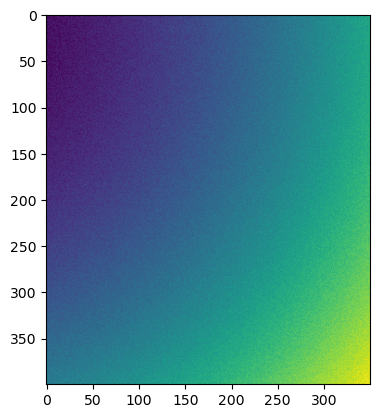

In [63]:
plt.figure()
plt.imshow(phase)

# Constructing a wavefront given Zernike Coefficients